In [11]:
import numpy as np
import matplotlib.pyplot as plt
from deap import creator, base, tools, algorithms


In [12]:
class LinearRegression:

    def fit(self, X, y):
        X = np.array(X)
        y = np.array(y)
        self.X_train = X / (np.amax(y))
        self.y_train = y / (np.amax(y))
        self.N_train = X.shape[0]
        self.M = X.shape[1]


    def to_int_tpl_map(self, line):
        return tuple(map(int, line.strip().split()))


    def fit_from_file(self, file_name=None, file=None):
        if file_name:
            file = open(file_name)
        raw_data = tuple(map(self.to_int_tpl_map, file.readlines()))
        self.M = int(raw_data[0][0])
        self.N_train = int(raw_data[1][0])
        train_data = np.array(raw_data[2:self.N_train+2])
        self.y_train = train_data[:, -1] / np.amax(train_data[:, -1])
        self.X_train = train_data[:,:-1] / np.amax(train_data[:, -1])
        self.N_test = int(raw_data[self.N_train+2][0])
        test_data = np.array(raw_data[self.N_train+3:])
        self.y_test = test_data[:,-1]
        self.X_test = test_data[:,:-1]


    def rmse_loss(self, y_pred):
        return np.sqrt((((y_pred - self.y_train)**2).sum())/self.N_train)

    def SVD(self):
        self.w = np.linalg.pinv(self.X_train) @ self.y_train


    def gradient(self, lr=0.01, batch_size=75, n_epochs=100000):

        def loss_derivative(y, y_pred):
            return -2 * (y - y_pred)
        self.w = np.random.sample(self.M)
        for it in range(n_epochs):
            if it % batch_size == 0:
                y_pred = self.X_train @ self.w
                loss_der = loss_derivative(self.y_train, y_pred)
                grad = (np.array([self.X_train[n]*loss_der[n] for n in range(self.N_train)])).sum(axis=0)/self.N_train
                # print('grad:', ' '.join(map(str, grad)))
            self.w = self.w - lr * grad


    def genetic(self, n_epochs=40):
        creator.create("FitnessMax", base.Fitness, weights=(-1.0,))
        creator.create("Individual", np.ndarray, fitness=creator.FitnessMax)

        toolbox = base.Toolbox()

        toolbox.register("attr_float", np.random.random)
        toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=self.M)
        toolbox.register("population", tools.initRepeat, list, toolbox.individual)

        def eval_def(individual):
            return self.rmse_loss(self.X_train @ individual),

        toolbox.register("evaluate", eval_def)
        toolbox.register("mate", tools.cxTwoPoint)
        toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
        toolbox.register("select", tools.selTournament, tournsize=3)

        population = toolbox.population(n=300)

        for gen in range(n_epochs):
            offspring = algorithms.varAnd(population, toolbox, cxpb=0.5, mutpb=0.1)
            fits = toolbox.map(toolbox.evaluate, offspring)
            for fit, ind in zip(fits, offspring):
                ind.fitness.values = fit
            population = toolbox.select(offspring, k=len(population))
        self.w = tools.selBest(population, k=1)[0]


    def nrmse_score(self, X_test=None, y_test=None):
        if X_test:
            self.X_test = X_test
        if X_test:
            self.y_test = y_test
        y_pred = self.X_test @ self.w
        return np.sqrt(((y_pred - self.y_test)**2).sum()/self.y_test.shape[0])/(np.amax(self.y_test) - np.amin(self.y_test))


    def smape_score(self, X_test=None, y_test=None):
        if X_test and y_test:
            self.X_test = np.array(X_test)
            self.y_test = np.array(y_test)
            self.N_test = self.y_test.shape[0]
        y_pred = self.X_test  @ self.w
        return (100/self.N_test) * (np.absolute(self.y_test - y_pred)/(np.absolute(self.y_test) + np.absolute(y_pred))).sum()


In [13]:
reg = LinearRegression()
reg.fit_from_file("6.txt")

In [14]:
reg.SVD()
print('SVD smape: ', reg.smape_score())

SVD smape:  0.392584289961708


In [15]:
grad_res = []
for n_epochs in [100, 500, 1000, 10000, 100000]:
    for batch_size in [100, 75, 50, 20, 10, 5 ,1]:
        for lr in 10.**np.arange(-4, -1):
            reg.gradient(lr=lr, batch_size=batch_size, n_epochs=n_epochs)
            smape = reg.smape_score()
            nrmse = reg.nrmse_score()
            grad_res.append([lr, batch_size, n_epochs, smape, nrmse])
            print('gradient: lr_%f, batch_size_%d, n_epochs_%d'%(lr, batch_size, n_epochs),smape)

sorted_res = sorted(grad_res, key=lambda x: x[4])[:10]
print('grad_top10: lr    batch size  n epochs    smape   nrmse\n', '\n'.join([' '.join(map(str, line)) for line in sorted_res]))

gradient: lr_0.000100, batch_size_100, n_epochs_100 33.9316740442396
gradient: lr_0.001000, batch_size_100, n_epochs_100 4.494616404745317
gradient: lr_0.010000, batch_size_100, n_epochs_100 15.303901751407317
gradient: lr_0.000100, batch_size_75, n_epochs_100 17.20646737086759
gradient: lr_0.001000, batch_size_75, n_epochs_100 18.722386191491314
gradient: lr_0.010000, batch_size_75, n_epochs_100 11.477752570290203
gradient: lr_0.000100, batch_size_50, n_epochs_100 14.805991589311935
gradient: lr_0.001000, batch_size_50, n_epochs_100 17.798216198694394
gradient: lr_0.010000, batch_size_50, n_epochs_100 19.426776887620147
gradient: lr_0.000100, batch_size_20, n_epochs_100 15.420921126924995
gradient: lr_0.001000, batch_size_20, n_epochs_100 18.428794143753503
gradient: lr_0.010000, batch_size_20, n_epochs_100 16.008154026769724
gradient: lr_0.000100, batch_size_10, n_epochs_100 8.752449073336619
gradient: lr_0.001000, batch_size_10, n_epochs_100 13.968286249319906
gradient: lr_0.010000,

In [16]:
grad_top5 = sorted_res

In [17]:
print('grad_top5: lr    batch size  n epochs    smape   nrmse\n', '\n'.join([' '.join(map(str, line)) for line in grad_top5]))

grad_top5: lr    batch size  n epochs    smape   nrmse
 0.01 50 100000 0.32383943364699747 0.0007607634070993455
0.0001 100 100000 0.6600604861634508 0.0008749526100224452
0.01 1 100000 0.8544749158210809 0.001997899181375605
0.01 10 100000 1.2847590766123458 0.0029069617750340612
0.01 75 100000 1.2958441298598684 0.0029289290420540497
0.01 1 10000 1.985160665488693 0.003359663255556548
0.001 5 100000 2.019539856902535 0.003364362398069937
0.01 100 100000 1.6925340677790457 0.00372503531408091
0.01 5 100000 2.117828326607947 0.004909211282189061
0.001 20 100000 2.5933536917702544 0.005126057565031591


In [18]:
grad_x_plot = list(range(100, 1000, 100))
grad_x_plot.extend(list(range(1000, 10000, 1000)))
grad_x_plot.extend(list(range(10000, 100001, 10000)))
grad_y_plot = []
for n_epochs in grad_x_plot:
    print(n_epochs, end='... ')
    grad_top1 = grad_top5[0]
    reg.gradient(lr=grad_top1[0], batch_size=grad_top1[1], n_epochs=n_epochs)
    # reg.gradient(n_epochs=n_epochs)
    grad_y_plot.append(reg.smape_score())


100... 200... 300... 400... 500... 600... 700... 800... 900... 1000... 2000... 3000... 4000... 5000... 6000... 7000... 8000... 9000... 10000... 20000... 30000... 40000... 50000... 60000... 70000... 80000... 90000... 100000... 

In [19]:
grad_x_plot_copy = grad_x_plot.copy()
grad_y_plot_copy = grad_y_plot.copy()

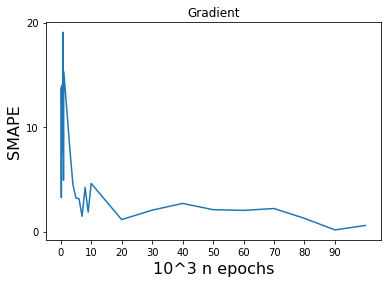

In [20]:
%matplotlib inline
plt.plot([ s/1000 for s in grad_x_plot], grad_y_plot)
plt.title("Gradient")
plt.ylabel('SMAPE', fontsize=16)
plt.xlabel('10^3 n epochs', fontsize=16)
plt.xticks(list(range(0,101,10)))
plt.yticks(list(range(int(min(grad_y_plot)//10)*10, int(max(grad_y_plot)//10 +2)*10,10)))
plt.show()

In [21]:
reg.genetic()
print(reg.nrmse_score())
print(reg.smape_score())

0.0015529514062703352
1.1917555616036868


In [22]:
genetic_x_plot = list(range(40))
genetic_y_plot = []
for n_epochs in genetic_x_plot:
    print(n_epochs, end='... ')
    reg.genetic(n_epochs=n_epochs)
    genetic_y_plot.append(reg.smape_score())
    print(' '.join(map(str, genetic_y_plot)))


0... 27.60226937199615
1... 27.60226937199615 4.6495898265636715
2... 27.60226937199615 4.6495898265636715 5.798593786515938
3... 27.60226937199615 4.6495898265636715 5.798593786515938 2.967818016862921
4... 27.60226937199615 4.6495898265636715 5.798593786515938 2.967818016862921 5.152306573241066
5... 27.60226937199615 4.6495898265636715 5.798593786515938 2.967818016862921 5.152306573241066 1.278003016826333
6... 27.60226937199615 4.6495898265636715 5.798593786515938 2.967818016862921 5.152306573241066 1.278003016826333 1.8613146673931442
7... 27.60226937199615 4.6495898265636715 5.798593786515938 2.967818016862921 5.152306573241066 1.278003016826333 1.8613146673931442 3.4561157916293874
8... 27.60226937199615 4.6495898265636715 5.798593786515938 2.967818016862921 5.152306573241066 1.278003016826333 1.8613146673931442 3.4561157916293874 3.214712328756163
9... 27.60226937199615 4.6495898265636715 5.798593786515938 2.967818016862921 5.152306573241066 1.278003016826333 1.8613146673931442

/home/neutralmike/Projects/ml_labs/venv/lib/python3.8/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/neutralmike/Projects/ml_labs/venv/lib/python3.8/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [23]:
genetic_x_plot_copy = genetic_x_plot.copy()
genetic_y_plot_copy = genetic_y_plot.copy()

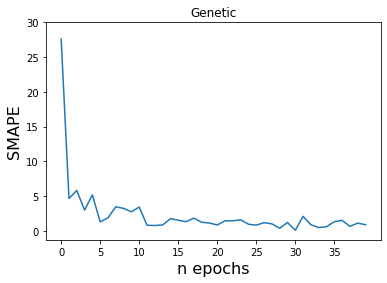

In [25]:
%matplotlib inline
plt.plot(genetic_x_plot, genetic_y_plot)
plt.title("Genetic")
plt.ylabel('SMAPE', fontsize=16)
plt.xlabel('n epochs', fontsize=16)
plt.xticks(list(range(0,40,5)))
plt.yticks(list(range(int(min(genetic_y_plot)//5)*5, int(max(genetic_y_plot)//5+2)*5, 5)))
plt.show()